# 42-43 bufio包中的数据类型

今天，我们来讲另一个与I/O操作强相关的代码包`bufio`。`bufio`是“buffered I/O”的缩写。顾名思义，**这个代码包中的程序实体实现的I/O操作都内置了缓冲区**。

`buffer i/o --- bufio`

`bufio`包中的数据类型主要有：

1. Reader；
2. Scanner；
3. Writer和ReadWriter。
与`io`包中的数据类型类似，这些类型的值也都需要在初始化的时候，包装一个或多个简单I/O接口类型的值。（这里的简单I/O接口类型指的就是`io`包中的那些简单接口。）

下面，我们将通过一系列问题对`bufio.Reader`类型和`bufio.Writer`类型进行讨论（以前者为主）。**今天我的问题是：`bufio.Reader`类型值中的缓冲区起着怎样的作用？**

**这道题的典型回答是这样的。**

`bufio.Reader`类型的值（以下简称`Reader`值）内的缓冲区，其实就是一个**数据存储中介，它介于底层读取器与读取方法及其调用方之间**。所谓的底层读取器，就是在初始化此类值的时候传入的`io.Reader`类型的参数值。

`Reader`值的读取方法一般都会先从其所属值的缓冲区中读取数据。同时，在必要的时候，它们还会预先从底层读取器那里读出一部分数据，并暂存于缓冲区之中以备后用。

有这样一个缓冲区的好处是，可以在大多数的时候**降低**读取方法的执行时间。虽然，读取方法有时还要负责填充缓冲区，但从总体来看，读取方法的平均执行时间一般都会因此有大幅度的缩短。

bufio.Reader 就是用“一次性从硬盘搬一大箱数据到内存”的方式，避免了“每读一个字就跑一趟硬盘”的笨办法，从而极大地提高了程序的运行速度。

## 问题解析

`bufio.Reader`类型并不是开箱即用的，因为它包含了一些需要显式初始化的字段。为了让你能在后面更好地理解它的读取方法的内部流程，我先在这里简要地解释一下这些字段，如下所示。

1. buf：[]byte类型的字段，即字节切片，代表缓冲区。虽然它是切片类型的，但是其长度却会在初始化的时候指定，并在之后保持不变。
2. rd：io.Reader类型的字段，代表底层读取器。缓冲区中的数据就是从这里拷贝来的。
3. r：int类型的字段，代表对缓冲区进行下一次读取时的开始索引。我们可以称它为已读计数。
4. w：int类型的字段，代表对缓冲区进行下一次写入时的开始索引。我们可以称之为已写计数。
5. err：error类型的字段。它的值用于表示在从底层读取器获得数据时发生的错误。这里的值在被读取或忽略之后，该字段会被置为nil。
6. lastByte：int类型的字段，用于记录缓冲区中最后一个被读取的字节。读回退时会用到它的值。
7. lastRuneSize：int类型的字段，用于记录缓冲区中最后一个被读取的Unicode字符所占用的字节数。读回退的时候会用到它的值。这个字段只会在其所属值的ReadRune方法中才会被赋予有意义的值。在其他情况下，它都会被置为-1。

`bufio`包为我们提供了两个用于初始化`Reader`值的函数，分别叫：

- `NewReader`；

- `NewReaderSize`；

它们都会返回一个`*bufio.Reader`类型的值。

`NewReader`函数初始化的`Reader`值会拥有一个默认尺寸的缓冲区。这个默认尺寸是`4096`个字节，即：`4` KB。而`NewReaderSize`函数则将缓冲区尺寸的决定权抛给了使用方。

由于这里的缓冲区在一个`Reader`值的**生命周期内其尺寸不可变**，所以在有些时候是需要做一些权衡的。`NewReaderSize`函数就提供了这样一个途径。

在`bufio.Reader`类型拥有的读取方法中，`Peek`方法和`ReadSlice`方法都会调用该类型一个名为`fill`的包级私有方法。`fill`方法的作用是填充内部缓冲区。我们在这里就先重点说说它。

`fill`方法会先检查其所属值的已读计数。如果这个计数不大于0，那么有两种可能。

**一种可能是其缓冲区中的字节都是全新的，也就是说它们都没有被读取过，另一种可能是缓冲区刚被压缩过。** 注意此处的压缩是指内存数据的搬运，即将缓冲区中还没有读完的有效数据全部移动到缓存区的头部。

对缓冲区的压缩包括两个步骤。**第一步，把缓冲区中在[已读计数, 已写计数)范围之内的所有元素值（或者说字节）都依次拷贝到缓冲区的头部。**

比如，把缓冲区中与已读计数代表的索引对应字节拷贝到索引0的位置，并把紧挨在它后边的字节拷贝到索引1的位置，以此类推。

这一步之所以不会有任何副作用，是因为它基于两个事实。

1. 第一事实，已读计数之前的字节都已经被读取过，并且肯定不会再被读取了，因此把它们覆盖掉是安全的。

2. 第二个事实，在压缩缓冲区之后，已写计数之后的字节只可能是已被读取过的字节，或者是已被拷贝到缓冲区头部的未读字节，又或者是代表未曾被填入数据的零值0x00。所以，后续的新字节是可以被写到这些位置上的。

**在压缩缓冲区的第二步中，`fill`方法会把已写计数的新值设定为原已写计数与原已读计数的差。这个差所代表的索引，就是压缩后第一次写入字节时的开始索引。**

另外，该方法还会把已读计数的值置为`0`。显而易见，在压缩之后，再读取字节就肯定要从缓冲区的头部开始读了。

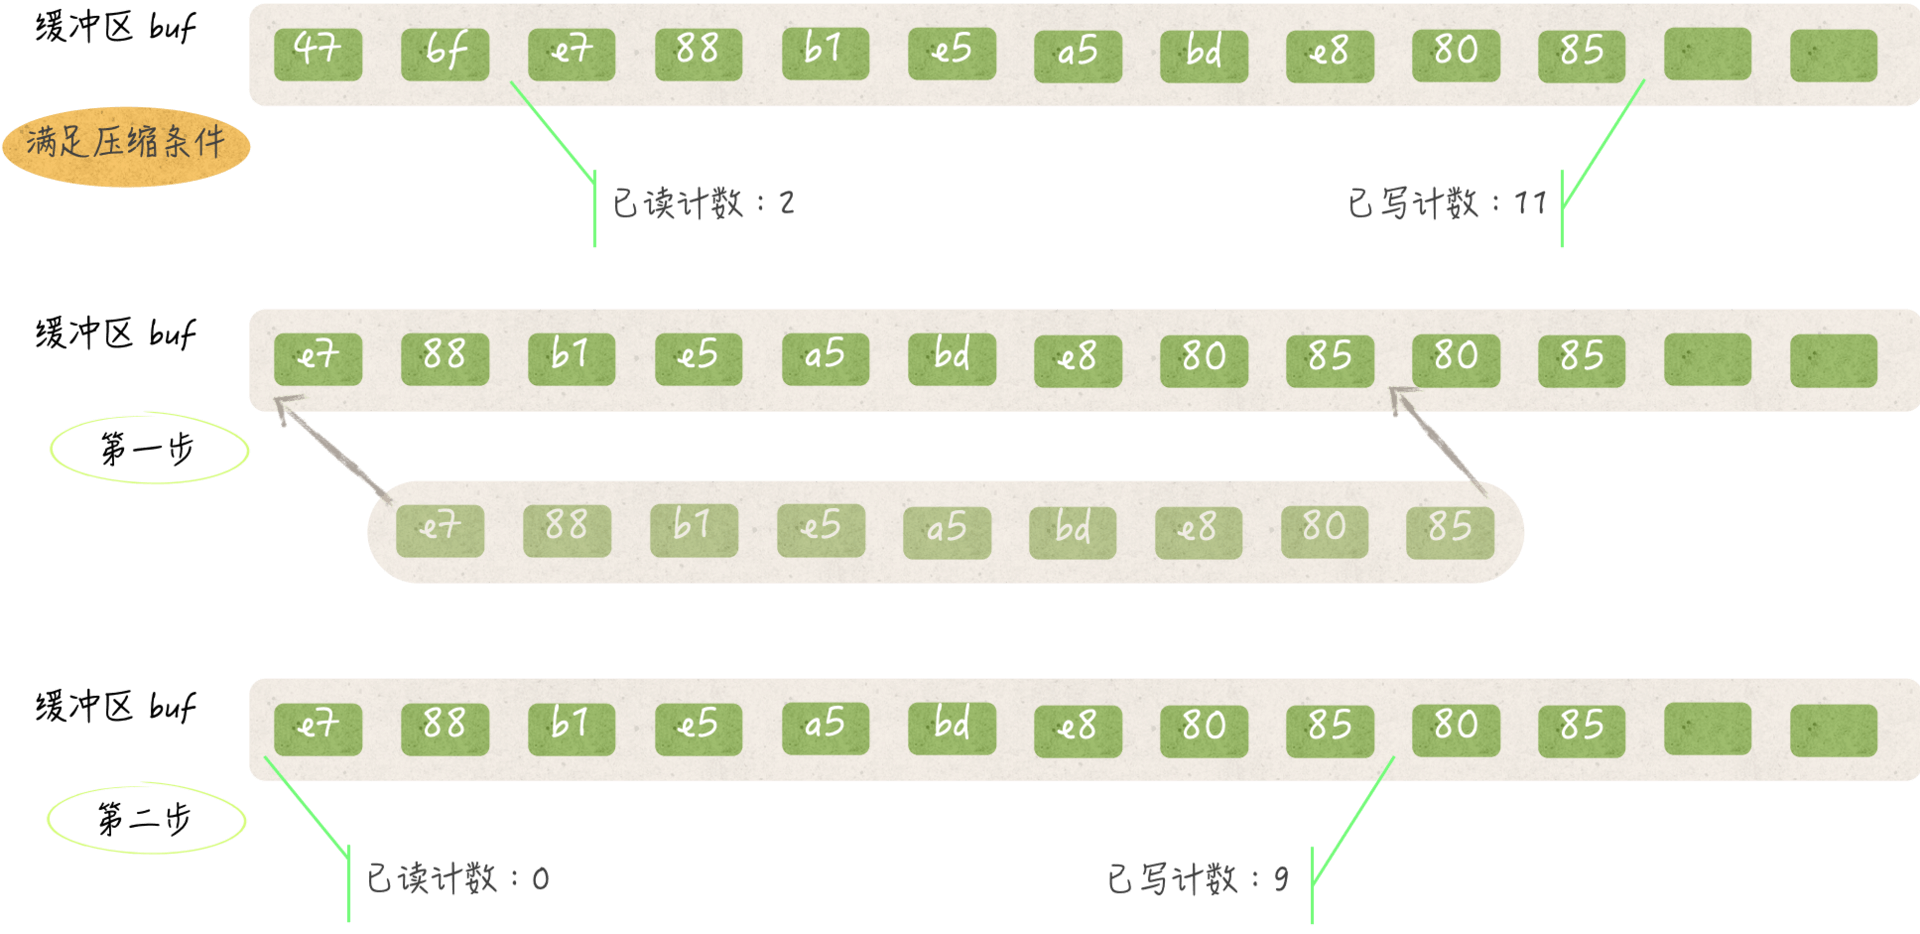

（bufio.Reader中的缓冲区压缩）

实际上，`fill`方法只要在开始时发现其所属值的已读计数大于`0`，就会对缓冲区进行一次压缩。之后，如果缓冲区中还有可写的位置，那么该方法就会对其进行填充。

在填充缓冲区的时候，`fill`方法会试图从底层读取器那里，读取足够多的字节，并尽量把从已写计数代表的索引位置到缓冲区末尾之间的空间都填满。

在这个过程中，`fill`方法会及时地更新已写计数，以保证填充的正确性和顺序性。另外，它还会判断从底层读取器读取数据的时候，是否有错误发生。如果有，那么它就会把错误值赋给其所属值的`err`字段，并终止填充流程。

好了，到这里，我们暂告一个段落。在本题中，我对`bufio.Reader`类型的基本结构，以及相关的一些函数和方法进行了概括介绍，并且重点阐述了该类型的`fill`方法。

后者是我们在后面要说明的一些读取流程的重要组成部分。你起码要记住的是：这个`fill`方法大致都做了些什么。

## 知识扩展

**问题1：`bufio.Writer`类型值中缓冲的数据什么时候会被写到它的底层写入器？**

我们先来看一下`bufio.Writer`类型都有哪些字段：

1. err：error类型的字段。它的值用于表示在向底层写入器写数据时发生的错误。
2. buf：[]byte类型的字段，代表缓冲区。在初始化之后，它的长度会保持不变。
3. n：int类型的字段，代表对缓冲区进行下一次写入时的开始索引。我们可以称之为已写计数。
4. wr：io.Writer类型的字段，代表底层写入器。
`bufio.Writer`类型有一个名为`Flush`的方法，它的主要功能是把相应缓冲区中暂存的所有数据，都写到底层写入器中。数据一旦被写进底层写入器，该方法就会把它们从缓冲区中删除掉。

不过，这里的删除有时候只是**逻辑上的删除**而已。不论是否成功地写入了所有的暂存数据，`Flush`方法都会妥当处置，并保证不会出现**重写**和**漏写**的情况。该类型的字段`n`在此会起到很重要的作用。

`bufio.Writer`类型值（以下简称`Writer`值）拥有的所有数据写入方法都会在必要的时候调用它的`Flush`方法。

比如，`Write`方法有时候会在把数据写进缓冲区之后，调用`Flush`方法，以便为后续的新数据腾出空间。`WriteString`方法的行为与之类似。

又比如，`WriteByte`方法和`WriteRune`方法，都会在发现缓冲区中的可写空间不足以容纳新的字节，或`Unicode`字符的时候，调用`Flush`方法。

**此外，如果`Write`方法发现需要写入的字节太多，同时缓冲区已空，那么它就会跨过缓冲区，并直接把这些数据写到底层写入器中。**

而`ReadFrom`方法，则会在发现`底层写入器`的类型是`io.ReaderFrom`接口的实现之后，直接调用其`ReadFrom`方法把参数值持有的数据写进去。

总之，在通常情况下，只要缓冲区中的可写空间无法容纳需要写入的新数据，`Flush`方法就一定会被调用。并且，`bufio.Writer`类型的一些方法有时候还会试图走捷径，跨过缓冲区而直接对接数据供需的双方。

你可以在理解了这些内部机制之后，有的放矢地编写你的代码。不过，在你把所有的数据都写入`Writer`值之后，再调用一下它的`Flush`方法，显然是最稳妥的。


In [ ]:
package main

import (
	"bufio"
	"fmt"
	"io"
	"strings"
)

// --- 场景一：普通底层写入器 ---
// BasicWriter 只实现了 Write 方法
type BasicWriter struct{}

func (bw *BasicWriter) Write(p []byte) (n int, err error) {
	fmt.Printf("   [底层调用] BasicWriter.Write 被调用了! 写入了 %d 字节 (数据被搬运了)\n", len(p))
	return len(p), nil
}

// --- 场景二：高级底层写入器 ---
// SmartWriter 既实现了 Write，又实现了 ReadFrom
type SmartWriter struct{}

func (sw *SmartWriter) Write(p []byte) (n int, err error) {
	fmt.Println("   [底层调用] SmartWriter.Write 被调用了 (不应该看到这个)")
	return len(p), nil
}

// ReadFrom 是优化的接口
func (sw *SmartWriter) ReadFrom(r io.Reader) (n int64, err error) {
	fmt.Println("   [底层调用] ★ SmartWriter.ReadFrom 被直接调用了! (触发了直通车优化)")
	// 模拟直接从 r 读取所有数据
	return io.Copy(io.Discard, r)
}

func main() {
	// 准备一些数据源 (Source)
	dataSrc1 := strings.NewReader("Hello, Basic!")
	dataSrc2 := strings.NewReader("Hello, Smart!")

	fmt.Println("=== 测试 1: 底层只是个普通 Writer ===")
	basic := &BasicWriter{}
	// 包装进 bufio
	bufioBasic := bufio.NewWriter(basic)
	// 调用 bufio 的 ReadFrom
	bufioBasic.ReadFrom(dataSrc1)
	// 必须 Flush 确保数据落地
	bufioBasic.Flush()

	fmt.Println("\n=== 测试 2: 底层实现了 ReaderFrom (这就是你问的情况) ===")
	smart := &SmartWriter{} //底层写入器
	// 包装进 bufio
	bufioSmart := bufio.NewWriter(smart)
	// 调用 bufio 的 ReadFrom
	bufioSmart.ReadFrom(dataSrc2)
	// 注意：在这种情况下，flush 其实都不需要，因为数据直接走了
}


// 注意此处&SmartWriter是目的地比如文件硬盘网卡，
// 而bufio.NewWriter是为了提高写入效率的缓冲区。

## 总结
今天我们从“bufio.Reader类型值中的缓冲区起着怎样的作用”这道问题入手，介绍了一部分bufio包中的数据类型，在下一次的分享中，我会沿着这个问题继续展开。

# 43 - 下
在上一篇文章中，我提到了bufio包中的数据类型（结构体）主要有Reader、Scanner、Writer和ReadWriter。并着重讲到了bufio.Reader类型与bufio.Writer类型，今天，我们继续专注bufio.Reader的内容来进行学习。

In [ ]:
// 这就是所谓的“数据类型”的真面目
type Reader struct {
    buf          []byte       // 核心数据1：那个传说中的“缓冲区”数组
    rd           io.Reader    // 核心数据2：底层的数据源（你塞进去的那个东西）
    r, w         int          // 核心数据3：读写游标（记录读到哪了，写到哪了）
    err          error        // 核心数据4：有没有报错
    lastByte     int          // 核心数据5：上一个读的字节（用于回退）
} 

// 注意这个bufio.Reader是io.Reader的实现类型

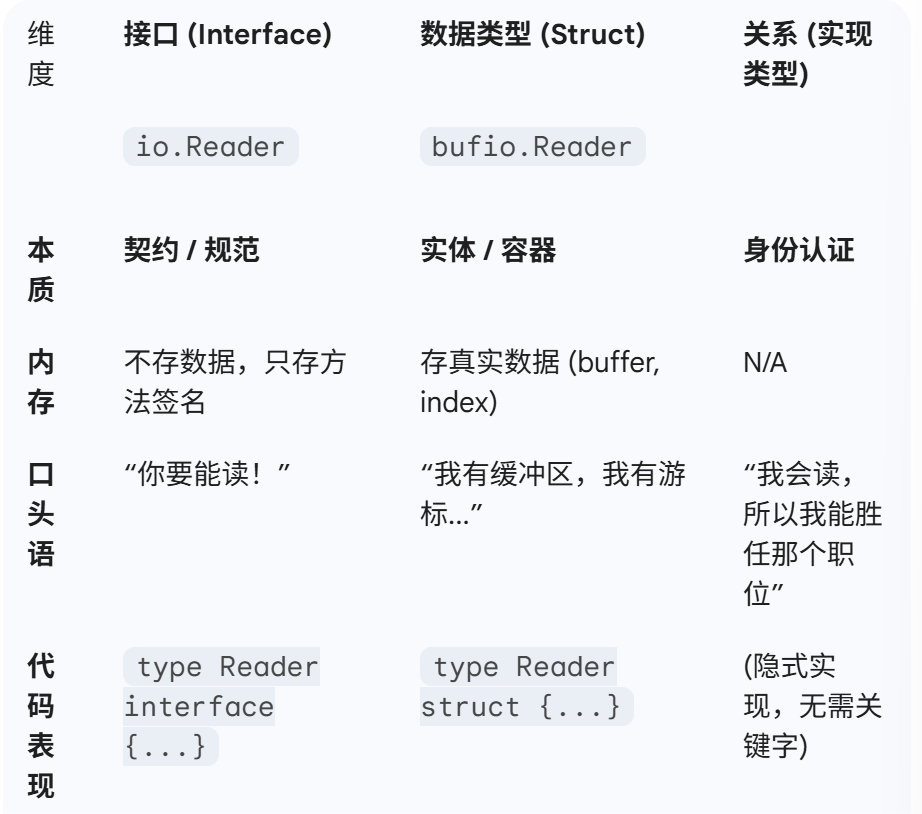

## 知识扩展
**问题 ：bufio.Reader类型读取方法有哪些不同？**

`bufio.Reader`类型拥有很多用于读取数据的指针方法，这里面有**4个方法可以作为不同读取流程的代表**，它们是：`Peek`、`Read`、`ReadSlice`和`ReadBytes`。

`Reader`值的`Peek`方法的功能是：**读取并返回其缓冲区中的n个未读字节，并且它会从已读计数代表的索引位置开始读**。

在缓冲区未被填满，并且其中的未读字节的数量小于`n`的时候，该方法就会调用`fill`方法，以启动缓冲区填充流程。但是，如果它发现上次填充缓冲区的时候`有错误`，那就不会再次填充。

如果调用方给定的`n`比缓冲区的长度还要大，或者缓冲区中未读字节的数量小于`n`，那么`Peek`方法就会把“所有未读字节组成的序列”作为第一个结果值返回。

同时，它通常还把“`bufio.ErrBufferFull`变量的值（以下简称缓冲区已满的错误）”- 作为第二个结果值返回，用来表示：虽然缓冲区被压缩和填满了，但是仍然满足不了要求。

只有在上述的情况都没有出现时，`Peek`方法才能返回：“以已读计数为起始的n个字节”和“表示未发生任何错误的`nil`”。

`bufio.Reader`类型的`Peek`方法有一个鲜明的特点，那就是：**即使它读取了缓冲区中的数据，也不会更改已读计数的值。**

这个类型的其他读取方法并不是这样。就拿该类型的`Read`方法来说，它有时会把缓冲区中的未读字节，依次拷贝到其`参数p`代表的字节切片中，**并立即根据实际拷贝的字节数增加已读计数的值。**

在缓冲区中还有未读字节的情况下，该方法的做法就是如此。不过，在另一些时候，其所属值的已读计数会等于已写计数，这表明：**此时的缓冲区中已经没有任何未读的字节了**。

当缓冲区中已无未读字节时，`Read`方法会先检查参数`p`的长度是否大于或等于缓冲区的长度。如果是，那么`Read`方法会索性放弃向缓冲区中填充数据，转而直接从其底层读取器中读出数据并拷贝到`p`中。**这意味着它完全跨过了缓冲区，并直连了数据供需的双方。**

需要注意的是，`Peek`方法在遇到类似情况时的做法与这里的区别（这两种做法孰优孰劣还要看具体的使用场景）。

`Peek`方法会在条件满足时填充缓冲区，并在发现参数`n`的值比缓冲区的长度更大时，直接返回缓冲区中的所有未读字节。

如果我们当初设定的缓冲区长度很大，那么在这种情况下的方法执行**耗时**，就有可能会比较长。最主要的原因是填充缓冲区需要花费较长的时间。

由`fill`方法执行的流程可知，它会尽量填满缓冲区中的可写空间。然而，`Read`方法在大多数的情况下，是不会向缓冲区中写入数据的，尤其是在前面描述的那种情况下，即：**缓冲区中已无未读字节，且参数p的长度大于或等于缓冲区的长度。**

此时，该方法会直接从`底层读取器`那里读出数据，所以数据的读出速度就成为了这种情况下方法执行耗时的决定性因素。

当然了，我在这里说的只是耗时操作在某些情况下更可能出现在哪里，一切的结论还是要以性能测试的客观结果为准。

说回`Read`方法的内部流程。如果缓冲区中已无未读字节，但其长度比参数`p`的长度更大，那么该方法会先把已读计数和已写计数的值都重置为0，然后再尝试着使用从底层读取器那里获取的数据，对缓冲区进行一次从头至尾的填充。**注意此处不是调用`fill`这个方法**

不过要注意，这里的尝试只会进行一次。无论在这一时刻是否能够获取到数据，也无论获取时是否有错误发生，都会是如此。而`fill`方法的做法与此不同，只要没有发生错误，它就会进行`多次`尝试，因此它真正获取到一些数据的可能性更大。

不过，这两个方法有一点是相同，那就是：**只要它们把获取到的数据写入缓冲区，就会及时地更新已写计数的值**。

再来说`ReadSlice`方法和`ReadBytes`方法。 这两个方法的功能总体上来说，**都是持续地读取数据，直至遇到调用方给定的分隔符为止。**

`ReadSlice`方法会先在其缓冲区的未读部分中寻找分隔符。如果未能找到，并且缓冲区未满，那么该方法会先通过调用`fill`方法对缓冲区进行填充，然后再次寻找，如此往复。

如果在填充的过程中发生了错误，那么它会把缓冲区中的未读部分作为结果返回，同时返回相应的错误值。

注意，在这个过程中有可能会出现虽然缓冲区已被填满，但仍然没能找到分隔符的情况。

这时，`ReadSlice`方法会把整个缓冲区（也就是buf字段代表的字节切片）作为第一个结果值，并把缓冲区已满的错误（即`bufio.ErrBufferFull`变量的值）作为第二个结果值。

经过`fill`方法填满的缓冲区肯定从头至尾都只包含了未读的字节，所以这样做是合理的。

当然了，一旦`ReadSlice`方法找到了分隔符，它就会在缓冲区上切出相应的、包含分隔符的字节切片，并把该切片作为结果值返回。无论分隔符找到与否，该方法都会正确地设置已读计数的值。

比如，在返回缓冲区中的所有未读字节，或者代表全部缓冲区的字节切片之前，它会把已写计数的值赋给已读计数，以表明缓冲区中已无未读字节。

如果说`ReadSlice`是一个容易半途而废的方法的话，那么可以说`ReadBytes`方法算得上是相当的执着。

`ReadBytes`方法会通过调用`ReadSlice`方法一次又一次地从缓冲区中读取数据，直至找到分隔符为止。

在这个过程中，`ReadSlice`方法可能会因缓冲区已满而返回所有已读到的字节和相应的错误值，但`ReadBytes`方法总是会**忽略**掉这样的错误，并再次调用`ReadSlice`方法，这使得后者会继续填充缓冲区并在其中寻找分隔符。

除非`ReadSlice`方法返回的错误值并不代表缓冲区已满的错误，或者它找到了分隔符，否则这一过程永远不会结束。

如果寻找的过程结束了，不管是不是因为找到了分隔符，`ReadBytes`方法都会把在这个过程中读到的所有字节，按照读取的先后顺序组装成一个字节切片，并把它作为第一个结果值。如果过程结束是因为出现错误，那么它还会把拿到的错误值作为第二个结果值。

在`bufio.Reader`类型的众多读取方法中，依赖`ReadSlice`方法的除了`ReadBytes`方法，还有`ReadLine`方法。不过后者在读取流程上并没有什么特别之处，我就不在这里赘述了。

另外，该类型的`ReadString`方法完全依赖于`ReadBytes`方法，前者只是在后者返回的结果值之上做了一个简单的类型转换而已。

最后，我还要提醒你一下，有个安全性方面的问题需要你注意。`bufio.Reader`类型的`Peek`方法、`ReadSlice`方法和`ReadLine`方法都有可能会造成内容泄露。

这主要是因为它们在正常的情况下都会**返回直接基于缓冲区的字节切片（指针）**。我在讲`bytes.Buffer`类型的时候解释过什么叫内容泄露。你可以返回查看。

调用方可以通过这些方法返回的结果值访问到缓冲区的其他部分，甚至修改缓冲区中的内容。这通常都是很危险的。

## 总结

我们用比较长的篇幅介绍了`bufio`包中的数据类型，其中的重点是`bufio.Reader`类型。

`bufio.Reader`类型代表的是携带缓冲区的读取器。它的值在被初始化的时候需要接受一个底层的读取器，后者的类型必须是`io.Reader`接口的实现。

`Reader`值中的缓冲区其实就是一个数据存储中介，它介于底层读取器与读取方法及其调用方之间。此类值的读取方法一般都会先从该值的缓冲区中读取数据，同时在必要的时候预先从其底层读取器那里读出一部分数据，并填充到缓冲区中以备后用。填充缓冲区的操作通常会由该值的`fill`方法执行。在填充的过程中，`fill`方法有时还会对缓冲区进行压缩。

在`Reader`值拥有的众多读取方法中，有4个方法可以作为不同读取流程的代表，它们是：Peek、Read、ReadSlice和ReadBytes。

- Peek方法的特点是即使读取了缓冲区中的数据，也不会更改已读计数的值。
- Read方法会在参数值的长度过大，且缓冲区中已无未读字节时，跨过缓冲区并直接向底层读取器索要数据。

- ReadSlice方法会在缓冲区的未读部分中寻找给定的分隔符，并在必要时对缓冲区进行填充。如果在填满缓冲区之后仍然未能找到分隔符，那么该方法就会把整个缓冲区作为第一个结果值返回，同时返回缓冲区已满的错误。

- ReadBytes方法会通过调用ReadSlice方法，一次又一次地填充缓冲区，并在其中寻找分隔符。除非发生了未预料到的错误或者找到了分隔符，否则这一过程将会一直进行下去。

Reader值的ReadLine方法会依赖于它的ReadSlice方法，而其ReadString方法则完全依赖于ReadBytes方法。

另外，值得我们特别注意的是，Reader值的Peek方法、ReadSlice方法和ReadLine方法都可能会造成其缓冲区中的内容的泄露。

最后再说一下`bufio.Writer`类型。把该类值的缓冲区中暂存的数据写进其底层写入器的功能，主要是由它的`Flush`方法实现的。

此类值的所有数据写入方法都会在必要的时候调用它的`Flush`方法。一般情况下，这些写入方法都会先把数据写进其所属值的缓冲区，然后再增加该值中的已写计数。但是，在有些时候，`Write`方法和`ReadFrom`方法也会跨过缓冲区，并直接把数据写进其底层写入器。

请记住，虽然这些写入方法都会不时地调用`Flush`方法，但是在写入所有的数据之后再显式地调用一下这个方法总是最稳妥的。

## 思考题
今天的思考题是：bufio.Scanner类型的主要功用是什么？它有哪些特点？
bufio.Scanner类型俗称带缓存的扫描器。它的功能还是比较强大的。

比如，我们可以自定义每次扫描的边界，或者说内容的分段方法。我们在调用它的Scan方法对目标进行扫描之前，可以先调用其Split方法并传入一个函数来自定义分段方法。

在默认情况下，扫描器会以行为单位对目标内容进行扫描。bufio代码包提供了一些现成的分段方法。实际上，扫描器在默认情况下会使用bufio.ScanLines函数作为分段方法。

又比如，我们还可以在扫描之前自定义缓存的载体和缓存的最大容量，这需要调用它的Buffer方法。在默认情况下，扫描器内部设定的最大缓存容量是64K个字节。

换句话说，目标内容中的每一段都不能超过64K个字节。否则，扫描器就会使它的Scan方法返回false，并通过其Err方法给予我们一个表示“token too long”的错误值。这里的“token”代表的就是一段内容。

关于bufio.Scanner类型的更多特点和使用注意事项，你可以通过它的文档获得。

In [ ]:
package main

import (
	"bufio"
	"fmt"
	"os"
)

func main() {
    // 打开一个文件（或者用 os.Stdin 读键盘输入）
    file, _ := os.Open("log.txt")
    defer file.Close()

    // 创建扫描器
    scanner := bufio.NewScanner(file)

    // 【核心魔法】
    // 只要还有下一行，scanner.Scan() 就返回 true
    // 遇到文件结束(EOF)或者出错，就返回 false，循环自动结束
    for scanner.Scan() {
        // scanner.Text() 自动帮你把这一行拿出来
        // 最棒的是：它自动帮你把末尾的换行符 (\n) 给去掉了！
        fmt.Println("读到一行：", scanner.Text())
    }

    // 必须检查一下循环是不是因为报错退出的
    if err := scanner.Err(); err != nil {
        fmt.Println("出错了：", err)
    }
}

In [ ]:
str := "Hello World  Go  Language"
scanner := bufio.NewScanner(strings.NewReader(str))

// 【大招】：把切分规则改为“按单词切分”
scanner.Split(bufio.ScanWords)

for scanner.Scan() {
    fmt.Println(scanner.Text())
}
// 输出：
// Hello
// World
// Go
// Language